## <div style= 'color: White'> This is the newer, updated and more sophisticated version of the code 

In [1]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt

### <div style= 'color: yellow'> Create dataset


In [2]:
# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
NUM_FILES_TO_USE = 399700
DATA_DIR_PATH = "/home/kay/ML-for-Neutron-Stars/3_PP_EOS_emulator_real_data/All_MR_Relations/All_MR_Relations/"
BATCH_SIZE = 256 # Larger batch size for smoother gradients
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Regex to extract parameters
pattern = re.compile(
    r"MREoSm(?P<m>\d+)"
    r"L(?P<L>\d+)"
    r"J(?P<J>\d+)"
    r"T(?P<T>\d+)_"
    r"n(?P<n>\d+)_"
    r"Yp?\+.*?RGgen_"
    r"v(?P<n_v>[-\d\.]+)"
    r"d(?P<d>[-\d\.]+)"
    r"B(?P<Btype>[np])(?P<B>\d+)\.dat"
)

# ==============================================================================
# 2. DATA PROCESSING (SPLIT BY FILE)
# ==============================================================================
all_files = glob.glob(os.path.join(DATA_DIR_PATH, "MR*.dat"))
if not all_files: raise RuntimeError("No files found.")

# Shuffle FILES first, then split
np.random.shuffle(all_files)
selected_files = all_files[:NUM_FILES_TO_USE]

# Split files into Train and Validation lists (80/20 split)
split_idx = int(0.8 * len(selected_files))
train_files = selected_files[:split_idx]
val_files = selected_files[split_idx:]

def process_files(file_list, label_desc):
    dataset_rows = []
    files_used_for_training = []
    
    for file_path in tqdm(file_list, desc=f"Processing {label_desc}"):
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if not match: continue

        files_used_for_training.append(file_path)

        # Extract ALL parameters
        m = float(match.group("m")) / 100.0 
        L = float(match.group("L"))
        J = float(match.group("J"))             
        T = float(match.group("T"))             
        n = float(match.group('n')) / 1000.0
        n_v = float(match.group("n_v"))
        d = float(match.group("d"))
        B = float(match.group("B")) / 1000.0
        
        try:
            data = np.loadtxt(file_path)
        except: continue

        if data.ndim == 1 or data.shape[1] < 3: continue

        # Columns: [Central pressure (P_c), Mass, Radius, Tidal Deformability, R_quarkcore, Baryonic mass (rho)]
        mass_raw = data[:, 1]
        radius_raw = data[:, 2]

        # Filter Unstable Branch
        max_m_index = np.argmax(mass_raw)

        SAFETY_MARGIN = 2
        end_index = max(1, max_m_index + 1 - SAFETY_MARGIN)

        mass_raw = mass_raw[:end_index]
        radius_raw = radius_raw[:end_index]

        # Low Minimum mass cutoff
        M_CUTOFF = 0.15
        mask = mass_raw >= M_CUTOFF
        mass_raw = mass_raw[mask]
        radius_raw = radius_raw[mask]

        # Basic filtering
        valid_mask = (mass_raw > 0) & (radius_raw > 0)
        mass_raw = mass_raw[valid_mask]
        radius_raw = radius_raw[valid_mask]

        if len(mass_raw) < 2:
            continue

        # --- Interpolate radius(M) ---
        mass_min = mass_raw.min()
        mass_max = mass_raw.max()

        mass = np.linspace(mass_min, mass_max, 200)
        radius = np.interp(mass, mass_raw, radius_raw)

        if len(mass) == 0: continue

        # Create feature vector for every point
        # Features: [m, L, J, n_v, d, B, n, Mass] -> Predict: Radius
        num_points = len(mass)
        eos_params = np.array([m, L, J, n_v, d, B, n])
        
        # Tile EOS params to match number of mass points
        eos_repeated = np.tile(eos_params, (num_points, 1))
        
        # Stack: [EOS_Params (7), Mass (1), Radius (1)]
        rows = np.column_stack([eos_repeated, mass, radius])
        dataset_rows.append(rows)

    if not dataset_rows: return None
    return np.vstack(dataset_rows), np.array(files_used_for_training)

print("Building Training Set...")
train_data = process_files(train_files, "Train")
print("Building Validation Set...")
val_data = process_files(val_files, "Val")
print("Datasets created!")

print(train_data[1].shape)
print(val_data[1].shape)

files_used_for_training = np.concatenate([train_data[1], val_data[1]]) if train_data and val_data is not None else []
print(f"Total files used for training and validation: {len(files_used_for_training)}")

save_dir = f"{NUM_FILES_TO_USE}files"
# Create folder if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, "train_data_files.npy"), train_data[0])
np.save(os.path.join(save_dir, "val_data_files.npy"), val_data[0])
np.save(os.path.join(save_dir, "files_used_for_training.npy"), files_used_for_training)

print("Datasets saved!")

Building Training Set...


Processing Train: 100%|██████████| 319760/319760 [09:45<00:00, 546.23it/s] 


Building Validation Set...


Processing Val: 100%|██████████| 79940/79940 [03:15<00:00, 408.11it/s]


Datasets created!
(319760,)
(79940,)
Total files used for training and validation: 399700
Datasets saved!


# <div style= 'color: red'> FROM HERE ON USE CLUSTER FILES train_real.py AND test.py, FOR BIGGER RUNS

### <div style= 'color: yellow'> Loading Datasets 

In [3]:
save_dir = "1000files/"

In [4]:
train_data = np.load(os.path.join(save_dir, "train_data_files.npy"))
val_data = np.load(os.path.join(save_dir, "val_data_files.npy"))
files_used_for_training = np.load(os.path.join(save_dir, "files_used_for_training.npy"))

### <div style= 'color: orange'> Range of values of the parameters from the dataset

In [5]:
print("Nuclear Mass min/max:", np.round(train_data[:, 0].min(), 3), np.round(train_data[:, 0].max(), 3))
print("Slope parmeter min/max:", np.round(train_data[:, 1].min(), 3), np.round(train_data[:, 1].max(), 3))
print("Symmetry Energy min/max:", np.round(train_data[:, 2].min(), 3), np.round(train_data[:, 2].max(), 3))
print("Vector coupling min/max:", np.round(train_data[:, 3].min(), 3), np.round(train_data[:, 3].max(), 3))
print("Dipole coupling min/max:", np.round(train_data[:, 4].min(), 3), np.round(train_data[:, 4].max(), 3))
print("Bag constant min/max:", np.round(train_data[:, 5].min(), 3), np.round(train_data[:, 5].max(), 3))
print("Number of particles min/max:", np.round(train_data[:, 6].min(), 3), np.round(train_data[:, 6].max(), 3))

print("Mass min/max:", np.round(train_data[:, 7].min(), 3), np.round(train_data[:, 7].max(), 3))
print("Radius min/max:", np.round(train_data[:, 8].min(), 3), np.round(train_data[:, 8].max(), 3))

train_data.shape

Nuclear Mass min/max: 0.55 0.75
Slope parmeter min/max: 40.0 145.0
Symmetry Energy min/max: 30.0 32.0
Vector coupling min/max: 0.0 1.52
Dipole coupling min/max: 0.9 2.0
Bag constant min/max: 0.0 0.2
Number of particles min/max: 0.15 0.16
Mass min/max: 0.15 3.351
Radius min/max: 6.86 24.894


(160000, 9)

### <div style= 'color: orange'> Produce a mass-radius curve for a single EOS

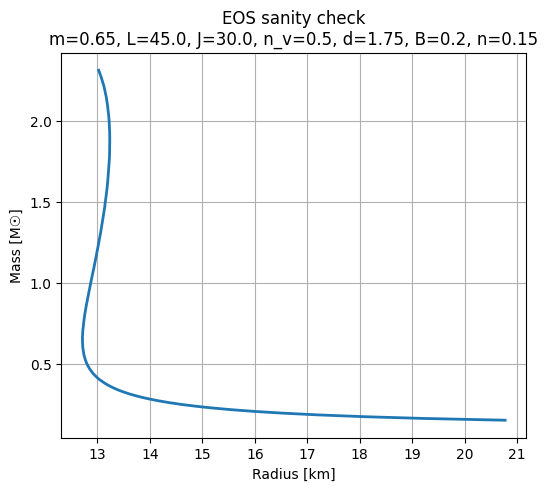

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# Extract ONE eos curve
# -------------------------------------------------------
# Pick a specific index (0 = first file in train_data before shuffling)
# But because the train_data is shuffled, we instead extract a *single EOS*
# by matching identical (m, L, J, n_v, d, B, n).
# Selecting the EOS at index 20000 for variety
m0, L0, J0, nv0, d0, B0, n0 = train_data[20000, :7]

mask = (
    (train_data[:,0] == m0)  &
    (train_data[:,1] == L0)  &
    (train_data[:,2] == J0)  &
    (train_data[:,3] == nv0) &
    (train_data[:,4] == d0)  &
    (train_data[:,5] == B0)  &
    (train_data[:,6] == n0)
)

subset = train_data[mask]

mass = subset[:, 7]
radius = subset[:, 8]

# Sort by mass so plot looks clean
order = np.argsort(mass)
mass = mass[order]
radius = radius[order]

# -------------------------------------------------------
# Plot
# -------------------------------------------------------
plt.figure(figsize=(6,5))
plt.plot(radius, mass, linewidth=2)
plt.xlabel("Radius [km]")
plt.ylabel("Mass [M☉]")
plt.title(f"EOS sanity check\nm={m0}, L={L0}, J={J0}, n_v={nv0}, d={d0}, B={B0}, n={n0}")
plt.grid(True)
plt.show()


### <div style= 'color: yellow'> Data processing pipeline

* Z_Score normalization: $X_{\text{norm}, i} = (X_i - \mu_i) / \sigma_i$
* Constant Scaling: $X_{\text{norm}, M} = X_M / 3.5$

In [7]:
# Convert to Tensor
# Inputs: Cols 0 to 7 (8 features: m, L, J, n_v, d, B, n, Mass)
# Output: Col 8 (Radius)
X_train = torch.tensor(train_data[:, :8], dtype=torch.float32)
y_train = torch.tensor(train_data[:, 8:], dtype=torch.float32)

X_val = torch.tensor(val_data[:, :8], dtype=torch.float32)
y_val = torch.tensor(val_data[:, 8:], dtype=torch.float32)

# Separate Mass (index 7) from EOS parameters (indices 0-7)
X_eos_train, X_mass_train = X_train[:, :7], X_train[:, 7:]
X_eos_val, X_mass_val = X_val[:, :7], X_val[:, 7:]

# 1. Normalize using Z-Score on EOS Parameters (m, L, J, n_v, d, B, n)
X_eos_mean = X_eos_train.mean(dim=0, keepdim=True)
X_eos_std = X_eos_train.std(dim=0, keepdim=True)
X_eos_std[X_eos_std == 0] = 1.0 

# Save them:
torch.save(X_eos_mean, os.path.join(save_dir, "X_eos_mean.pt"))
torch.save(X_eos_std, os.path.join(save_dir, "X_eos_std.pt"))
print("Normalization statistics saved.")

X_eos_train_norm = (X_eos_train - X_eos_mean) / X_eos_std
X_eos_val_norm = (X_eos_val - X_eos_mean) / X_eos_std

# 2. Normalize using Constant Scaling on Mass (M)
MASS_SCALE = 3.5 
X_mass_train_norm = X_mass_train / MASS_SCALE
X_mass_val_norm = X_mass_val / MASS_SCALE
# Recombine Inputs
X_train_norm = torch.cat((X_eos_train_norm, X_mass_train_norm), dim=1)
X_val_norm = torch.cat((X_eos_val_norm, X_mass_val_norm), dim=1)

# 3. Normalize using Constant Scaling on Radius (R)
RADIUS_SCALE = 25.0
y_train_norm = y_train / RADIUS_SCALE
y_val_norm = y_val / RADIUS_SCALE

# Note: You no longer need y_mean and y_std for normalization, 
# but you MUST save RADIUS_SCALE to de-normalize predictions later.

Normalization statistics saved.


### <div style= 'color: orange'> Range of values of the parameters after scaling and normalizing

In [8]:
print("Nuclear Mass min/max:", np.round(X_train_norm[:, 0].min(), 3), np.round(X_train_norm[:, 0].max(), 3))
print("Slope parmeter min/max:", np.round(X_train_norm[:, 1].min(), 3), np.round(X_train_norm[:, 1].max(), 3))
print("Symmetry Energy min/max:", np.round(X_train_norm[:, 2].min(), 3), np.round(X_train_norm[:, 2].max(), 3))
print("Vector coupling min/max:", np.round(X_train_norm[:, 3].min(), 3), np.round(X_train_norm[:, 3].max(), 3))
print("Dipole coupling min/max:", np.round(X_train_norm[:, 4].min(), 3), np.round(X_train_norm[:, 4].max(), 3))
print("Bag constant min/max:", np.round(X_train_norm[:, 5].min(), 3), np.round(X_train_norm[:, 5].max(), 3))
print("Number of particles min/max:", np.round(X_train_norm[:, 6].min(), 3), np.round(X_train_norm[:, 6].max(), 3))
print("Mass min/max:", np.round(X_train_norm[:, 7].min(), 3), np.round(X_train_norm[:, 7].max(), 3))

print("Radius min/max:", np.round(y_train_norm[:, 0].min(), 3), np.round(y_train_norm[:, 0].max(), 3))

Nuclear Mass min/max: tensor(-1.2140) tensor(1.8350)
Slope parmeter min/max: tensor(-1.2410) tensor(2.7790)
Symmetry Energy min/max: tensor(-1.2230) tensor(1.2480)
Vector coupling min/max: tensor(-2.0480) tensor(2.0430)
Dipole coupling min/max: tensor(-2.0310) tensor(2.0970)
Bag constant min/max: tensor(-1.6930) tensor(1.3580)
Number of particles min/max: tensor(-0.8730) tensor(1.1450)
Mass min/max: tensor(0.0430) tensor(0.9570)
Radius min/max: tensor(0.2740) tensor(0.9960)


### <div style= 'color: yellow'> Define Model

In [9]:
class ResNetBlock(nn.Module):
    def __init__(self, hidden_dim, auxiliary_dim=1):
        super().__init__()
        # We accept the hidden state + the auxiliary Mass injection
        self.fc = nn.Linear(hidden_dim + auxiliary_dim, hidden_dim)
        self.act = nn.GELU() # Gaussian Error Linear Unit
    
    def forward(self, x, mass):
        # Concatenate Mass to the input of the layer
        combined = torch.cat([x, mass], dim=1)
        out = self.act(self.fc(combined))
        return x + out # Residual connection

class PhysicsEmulator(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=512): 
        super().__init__()
        # Separate EOS inputs from Mass
        # input_dim is 8: (7 EOS params + 1 Mass)
        self.eos_dim = input_dim - 1 
        
        # 1. Initial encoding of EOS parameters only: 
        self.input_layer = nn.Linear(self.eos_dim, hidden_dim)
        
        # 2. Deep Residual Layers with Mass Injection
        self.block1 = ResNetBlock(hidden_dim, auxiliary_dim=1)
        self.block2 = ResNetBlock(hidden_dim, auxiliary_dim=1)
        self.block3 = ResNetBlock(hidden_dim, auxiliary_dim=1)
        self.block4 = ResNetBlock(hidden_dim, auxiliary_dim=1)

        # 3. Output layers
        self.final_layer = nn.Sequential(
            nn.Linear(hidden_dim + 1, hidden_dim // 2), # Inject mass one last time
            nn.GELU(),                                      # 513 --> 256
            nn.Linear(hidden_dim // 2, 1)                   # Output: 256 --> 1
        )
        
    def forward(self, x):
        # Split input into EOS params and Mass
        # Mass is the LAST column (index -1)
        eos_params = x[:, :-1]
        mass = x[:, -1:]
        
        # 1. Encode EOS
        x_hidden = self.input_layer(eos_params)             # Input: 7 --> 512
        
        # 2. Mass-Injected Residual Flow: Pass through blocks, injecting Mass at each step
        x_hidden = self.block1(x_hidden, mass)              # 512 + 1 --> 512
        x_hidden = self.block2(x_hidden, mass)              # 512 + 1 --> 512
        x_hidden = self.block3(x_hidden, mass)              # 512 + 1 --> 512
        x_hidden = self.block4(x_hidden, mass)              # 512 + 1 --> 512
        
        # 3. Final Prediction
        # Concatenate mass one last time for the read-out
        combined_final = torch.cat([x_hidden, mass], dim=1) # 512 + 1 = 513
        return self.final_layer(combined_final)             

### <div style= 'color: yellow'> Train Model

In [ ]:
# --- Helper function for plotting (needs to be defined before calling) ---
def plot_and_save_losses(train_losses, val_losses, filename="loss_curve.png"):
    """Plots training and validation loss and saves the figure."""
    epochs = range(len(train_losses))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    
    plt.title('Training and Validation Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Huber Loss (Normalized)')
    plt.yscale('log') # Use log scale for clearer visualization of small losses
    plt.legend()
    plt.grid(True, which="both", ls="--")
    
    try:
        plt.savefig(os.path.join(save_dir, filename))
        print(f"Loss plot saved to {filename}", flush=True)
    except Exception as e:
        print(f"ERROR saving plot: {e}", flush=True)
    plt.close() # Close the figure to free up memory
# --------------------------------------------------------------------------


model = PhysicsEmulator().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000, eta_min=1e-7)
criterion = nn.HuberLoss()

# ==============================================================================
# 5. TRAINING
# ==============================================================================
train_loader = DataLoader(TensorDataset(X_train_norm, y_train_norm), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_norm, y_val_norm), batch_size=BATCH_SIZE, shuffle=False)

epochs = 100 
best_loss = float('inf')

# 1. ADD STORAGE LISTS
train_losses = []
val_losses = []
# Ensure RADIUS_SCALE is defined globally or passed in if running as a function
# If you didn't define save_dir, model will save in current directory.

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_b, y_b in train_loader:
        X_b, y_b = X_b.to(DEVICE), y_b.to(DEVICE)
        optimizer.zero_grad()
        pred = model(X_b)
        loss = criterion(pred, y_b)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_b, y_b in val_loader:
            X_b, y_b = X_b.to(DEVICE), y_b.to(DEVICE)
            pred = model(X_b)
            loss = criterion(pred, y_b)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    scheduler.step()
    
    # 2. APPEND LOSSES
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        # Removed os.path.join(save_dir, "Best_EOS_Model.pth") for simplicity, assuming current directory
        torch.save(model.state_dict(), os.path.join(save_dir, "Best_EOS_Model.pth"))
    
    if epoch % 10 == 0:
        # Calculate the Approximate Physical Error in km
        phys_error_km = np.sqrt(2 * val_loss) * RADIUS_SCALE 
        
        print(f"Epoch {epoch} | Val Loss: {val_loss:.6e} | Approx Error: {phys_error_km:.4f} km", flush=True) 
        
        # 3. PLOT AND SAVE PERIODICALLY
        # Plot every 50 epochs (or choose a different interval)
        if epoch % 50 == 0 and epoch > 0:
            plot_and_save_losses(train_losses, val_losses, filename=f"loss_curve_epoch{epoch}.png")

# 4. FINAL PLOT after training finishes
plot_and_save_losses(train_losses, val_losses, filename="loss_curve_final.png")

### <div style= 'color: yellow'> Testing the model

Total files available: 399755
Training files loaded: 1000
Length of training set: 1000
Total unseen files available for testing: 398755
Testing on 10 unseen files.


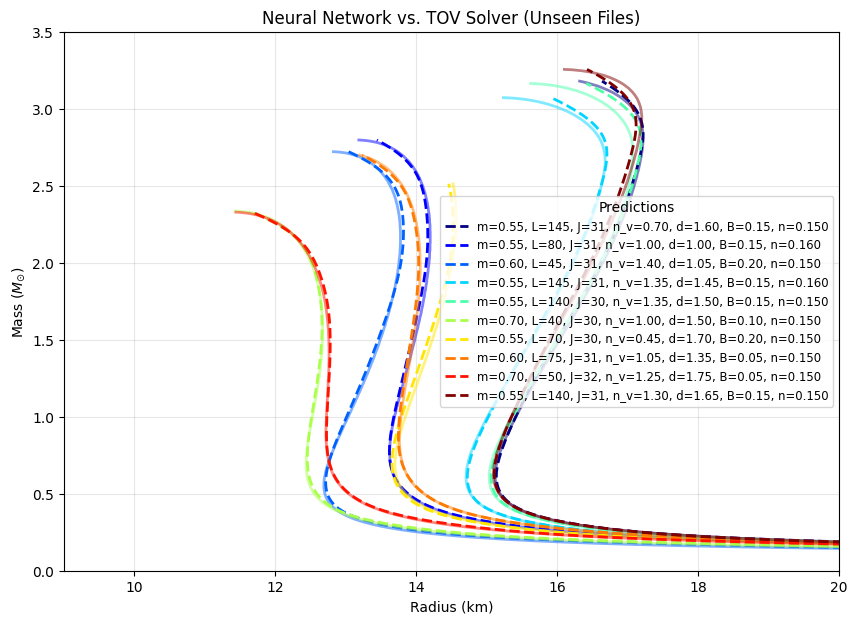

In [18]:
# ==============================================================================
# 1. CONFIGURATION & HELPERS
# ==============================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RADIUS_SCALE = 25.0
MASS_SCALE = 3.5

# Regex must match the Training Pipeline exactly
pattern = re.compile(
    r"MREoSm(?P<m>\d+)"
    r"L(?P<L>\d+)"
    r"J(?P<J>\d+)"
    r"T(?P<T>\d+)_"
    r"n(?P<n>\d+)_"
    r"Yp?\+.*?RGgen_"
    r"v(?P<n_v>[-\d\.]+)"
    r"d(?P<d>[-\d\.]+)"
    r"B(?P<Btype>[np])(?P<B>\d+)\.dat"
)

def extract_eos_params(filename):
    match = pattern.match(filename)
    if not match:
        return None
    
    # Extract raw values exactly like training
    m = float(match.group("m")) / 100.0
    L = float(match.group("L"))
    J = float(match.group("J"))
    n_v = float(match.group("n_v"))
    d = float(match.group("d"))
    B = float(match.group("B")) / 1000.0
    n = float(match.group('n')) / 1000.0  # e.g., 0.160
    
    # Return as a numpy array for easy stacking [m, L, J, n_v, d, B, n]
    return np.array([m, L, J, n_v, d, B, n], dtype=np.float32)

# ==============================================================================
# 2. SELECT "UNSEEN" FILES
# ==============================================================================
# Path to your data
DATA_DIR_PATH = "/home/kay/ML-for-Neutron-Stars/3_PP_EOS_emulator_real_data/All_MR_Relations/All_MR_Relations/"
all_files = glob.glob(os.path.join(DATA_DIR_PATH, "MR*.dat"))
print("Total files available:", len(all_files))

# Load the list of files used for training
# Ensure this file exists from your training run!
try:
    training_files_used = np.load(os.path.join(save_dir, "files_used_for_training.npy"), allow_pickle=True)
    print ("Training files loaded:", len(training_files_used))
    # Convert to set for fast lookup
    training_set = {
    os.path.basename(f) for f in training_files_used        
    }
    print("Length of training set:", len(training_set))
except FileNotFoundError:
    print("Warning: List of training files not found. Using random files (risk of data leakage).")
    # training_set = set()
    training_set = {
    os.path.basename(f) for f in training_files_used        
    }
    print("Length of random training set:", len(training_set))

# Filter: Keep only files NOT in the training set
test_pool = [
    f for f in all_files
    if os.path.basename(f) not in training_set
]
print("Total unseen files available for testing:", len(test_pool))

# Ensure we have enough unseen files
if len(test_pool) < 5:
    print("Warning: Not enough test files found. Check your paths.")
    selected_files = all_files[:5]
else:
    # Pick 10 random UNSEEN files <<--------------------------------------------
    selected_files = np.random.choice(test_pool, size=10, replace=False)
print(f"Testing on {len(selected_files)} unseen files.")

# ==============================================================================
# 3. PREPARE MODEL & SCALERS
# ==============================================================================
# Load Model
model = PhysicsEmulator(input_dim=8).to(DEVICE)
model.load_state_dict(torch.load(os.path.join(save_dir, "Best_EOS_Model.pth"), map_location=DEVICE))
model.eval()

# IMPORTANT: You must use the SAME mean/std from TRAINING.
# If you are in a new session, you should have saved these. 
# For now, assuming they exist in memory or you manually input them.
# Example: 
# X_eos_mean = torch.load("Datasets/X_eos_mean.pt")
# X_eos_std = torch.load("Datasets/X_eos_std.pt")

if 'X_eos_mean' not in locals():
    # Loading the SAME mean/std from TRAINING.
    X_eos_mean = torch.load(os.path.join(save_dir, "X_eos_mean.pt"), map_location=DEVICE)
    X_eos_std = torch.load(os.path.join(save_dir, "X_eos_std.pt"), map_location=DEVICE)
    print("ERROR: X_eos_mean and X_eos_std are missing!")
    print("You must save these during training or run this cell in the same notebook.")
else:
    X_eos_mean = X_eos_mean.to(DEVICE)
    X_eos_std = X_eos_std.to(DEVICE)

# ==============================================================================
# 4. EVALUATION LOOP
# ==============================================================================
plt.figure(figsize=(10, 7))
colors = plt.cm.jet(np.linspace(0, 1, len(selected_files)))

for color, file_path in zip(colors, selected_files):
    filename = os.path.basename(file_path)
    eos_params = extract_eos_params(filename)
    
    if eos_params is None: continue

    # Load Ground Truth Data
    try:
        data = np.loadtxt(file_path)
    except: continue
        
    # Get data columns
    mass_vals = data[:, 1]
    radius_vals = data[:, 2]
    
    # Filter stable branch (Up to Max Mass) same as training
    max_m_idx = np.argmax(mass_vals)
    # Apply the same safety margin cut as training
    SAFETY_MARGIN = 2
    cut_idx = max(1, max_m_idx - SAFETY_MARGIN) 
    
    mass_vals = mass_vals[:cut_idx]
    radius_vals = radius_vals[:cut_idx]

    # Low mass Mask ommited for testing to see full curve

    # Basic filtering to ensure positive values
    valid_mask = (radius_vals > 0) & (mass_vals > 0)
    mass_vals = mass_vals[valid_mask]
    radius_vals = radius_vals[valid_mask]

    # ---------------------------------------------------------
    # PREPARE INPUT TENSORS (The Hybrid Normalization)
    # ---------------------------------------------------------
    
    # 1. Tile the EOS params for every mass point
    num_points = len(mass_vals)
    eos_repeated = np.tile(eos_params, (num_points, 1)) # Shape (N, 7)
    
    # 2. Convert to Tensor
    X_eos_input = torch.tensor(eos_repeated, dtype=torch.float32).to(DEVICE)
    X_mass_input = torch.tensor(mass_vals.reshape(-1, 1), dtype=torch.float32).to(DEVICE)
    
    # 3. NORMALIZE (Use training stats!)
    # EOS: Z-score
    X_eos_norm = (X_eos_input - X_eos_mean) / X_eos_std
    # Mass: Constant Scaling
    X_mass_norm = X_mass_input / MASS_SCALE
    
    # 4. Concatenate
    model_input = torch.cat((X_eos_norm, X_mass_norm), dim=1)
    
    # ---------------------------------------------------------
    # PREDICT
    # ---------------------------------------------------------
    with torch.no_grad():
        # Predict normalized Radius (0.0 to ~1.0)
        R_pred_norm = model(model_input)
        
        # De-normalize: R_phys = R_norm * 25.0
        R_pred_km = R_pred_norm * RADIUS_SCALE
        
        # Move to CPU for plotting
        R_pred_km = R_pred_km.cpu().numpy().flatten()

    # ---------------------------------------------------------
    # PLOT [m, L, J, n_v, d, B, n] # Label with Physics Params
    # ---------------------------------------------------------
    label_txt = f"""m={eos_params[0]:.2f}, L={eos_params[1]:.0f}, J={eos_params[2]:.0f}, n_v={eos_params[3]:.2f}, d={eos_params[4]:.2f}, B={eos_params[5]:.2f}, n={eos_params[6]:.3f}""" 
    
    # Plot Ground Truth (Solid Line)
    plt.plot(radius_vals, mass_vals, "-", color=color, alpha=0.5, linewidth=2)
    
    # Plot Prediction (Dashed Line) 
    plt.plot(R_pred_km, mass_vals, "--", color=color, linewidth=2, label=label_txt)

plt.title("Neural Network vs. TOV Solver (Unseen Files)")
plt.xlabel("Radius (km)")
plt.ylabel(r"Mass ($M_{\odot}$)")
plt.legend(title="Predictions", fontsize='small')
plt.grid(True, alpha=0.3)
plt.xlim(9, 20)
plt.ylim(0, 3.5)
plt.savefig(os.path.join(save_dir, "Testing plot.png"))

plt.show()

### <div style= 'color: yellow'> Model Metrics

In [19]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

orig_radius_all = radius_vals
pred_radius_all = R_pred_km

mae_radius = mean_absolute_error(orig_radius_all, pred_radius_all)
rmse_radius = np.sqrt(mean_squared_error(orig_radius_all, pred_radius_all))
r2_radius = r2_score(orig_radius_all, pred_radius_all)

norm_rmse = np.mean([
    rmse_radius / np.mean(orig_radius_all)
])

print(f"Radius:  MAE={mae_radius:.4f}, RMSE={rmse_radius:.4f}, R²={r2_radius:.4f}")
print(f"Combined normalized RMSE = {norm_rmse:.4f}")

Radius:  MAE=0.0700, RMSE=0.1569, R²=0.9926
Combined normalized RMSE = 0.0094


In [20]:
# -----------------------------
# Save metrics to a text file
# -----------------------------
output_file = os.path.join(save_dir, "Model_metrics.txt")

with open(output_file, "w") as f:
    f.write("Radius prediction metrics with interpolated mass\n")
    f.write("================================================\n")
    f.write(f"MAE   : {mae_radius:.6f}\n")
    f.write(f"RMSE  : {rmse_radius:.6f}\n")
    f.write(f"R^2   : {r2_radius:.6f}\n")
    f.write(f"Norm RMSE : {norm_rmse:.6f}\n")

print(f"Metrics saved to {output_file}")


Metrics saved to 1000files/Model_metrics.txt
